## Computational Inteligence
## Project: A new approach using a genetic algorithm to CNN hyper-parameter adjustment on MNIST dataset.
### Ali Soltan Mohammdi
### ali.s.mohammadi@znu.ac.ir

### Add Libraryies

In [2]:
import pandas as pd
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.datasets import mnist
import keras
import matplotlib.pyplot as plt

### Read and prepare the MNIST dataset

In [4]:
# Load the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Preprocess the data
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

### Define the CNN model

Generation 1
Epoch 1/4
469/469 [==============================] - 114s 241ms/step - loss: 2.4848 - accuracy: 0.1066
Epoch 2/4
469/469 [==============================] - 113s 240ms/step - loss: 2.4523 - accuracy: 0.1120
Epoch 3/4
469/469 [==============================] - 113s 241ms/step - loss: 2.4071 - accuracy: 0.1382
Epoch 4/4
469/469 [==============================] - 113s 242ms/step - loss: 2.4350 - accuracy: 0.1256
Epoch 1/4
1875/1875 [==============================] - 134s 71ms/step - loss: 0.6116 - accuracy: 0.8141
Epoch 2/4
1875/1875 [==============================] - 126s 67ms/step - loss: 0.7038 - accuracy: 0.7825
Epoch 3/4
1875/1875 [==============================] - 124s 66ms/step - loss: 0.7552 - accuracy: 0.7630
Epoch 4/4
1875/1875 [==============================] - 124s 66ms/step - loss: 0.9241 - accuracy: 0.6973
Epoch 1/4
469/469 [==============================] - 133s 281ms/step - loss: 0.2084 - accuracy: 0.9354
Epoch 2/4
469/469 [==============================] - 132

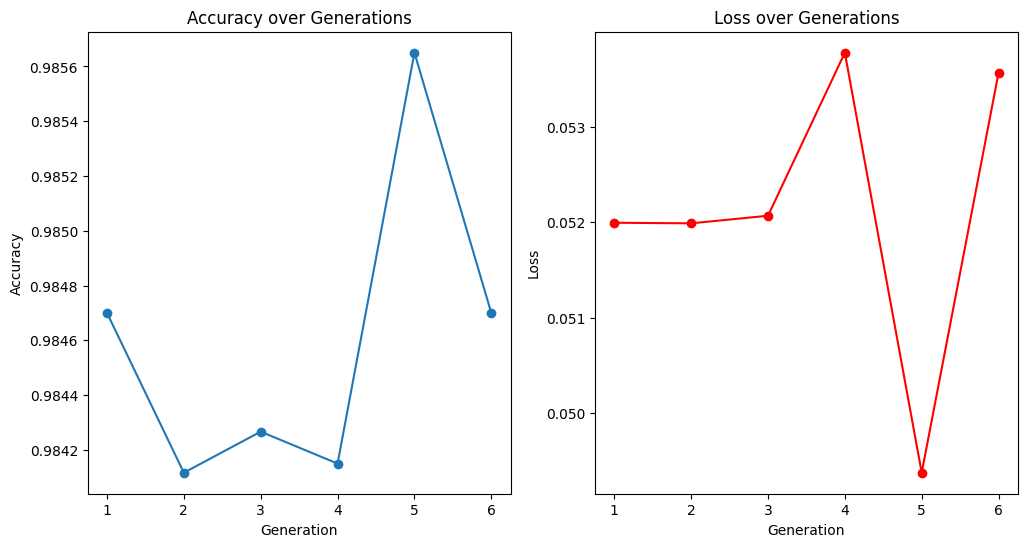

In [5]:
# Define the CNN model
def create_model(hidden_layers, activation, learning_rate, neurons, dropout, batch_size):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Genetic Algorithm functions
def create_chromosome():
    return {
        'hidden_layers': random.choice([1, 2, 3, 4]),
        'activation': random.choice(['relu', 'sigmoid', 'tanh']),
        'learning_rate': random.choice([0.001, 0.005, 0.01, 0.05, 0.1]),
        'neurons': random.choice([64, 128, 256]),
        'dropout': random.choice([0.2, 0.3, 0.4]),
        'batch_size': random.choice([8, 16, 32, 64, 128])
    }

# Crossover Function
def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        if isinstance(parent1[key], int):
            child[key] = random.choice([parent1[key], parent2[key]])
        else:
            child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
    return child

# Mutation Function
def mutate(chromosome):
    keys_to_mutate = random.sample(['learning_rate', 'neurons', 'dropout', 'batch_size'], 2)
    for key in keys_to_mutate:
        chromosome[key] *= 2
    return chromosome

# Evaluate Function
def evaluate_model(model, train_data, train_labels, batch_size):
    history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=4, verbose=1)
    return history.history['accuracy'][-1], history.history['loss'][-1]

# Genetic Algorithm and define genetic parameters
population_size = 10
generations = 6

population = [create_chromosome() for _ in range(population_size)]
best_fitness_scores = []

# Call genetic algorithm 
for generation in range(generations):
    print(f"Generation {generation + 1}")
    fitness_scores = []
    for chromosome in population:
        model = create_model(chromosome['hidden_layers'], chromosome['activation'], chromosome['learning_rate'], chromosome['neurons'], chromosome['dropout'], chromosome['batch_size'])
        accuracy, loss = evaluate_model(model, train_data, train_labels, chromosome['batch_size'])
        fitness_scores.append((accuracy, loss, chromosome))
    
    fitness_scores.sort(reverse=True)
    
    best_fitness_scores.append(fitness_scores[0])
    
    new_population = [fitness_scores[i][2] for i in range(int(population_size * 0.2))] # Keep top 20%
    
    while len(new_population) < population_size:
        parent1, parent2 = random.choices(population, k=2)
        child = crossover(parent1, parent2)
        if random.random() < 0.1: # Mutation rate of 10%
            child = mutate(child)
        new_population.append(child)
    
    population = new_population

# Print the best choromosome
best_chromosome = best_fitness_scores[-1][2]
print("Best Chromosome:", best_chromosome)

# Plotting the charts
accuracies = [score[0] for score in best_fitness_scores]
losses = [score[1] for score in best_fitness_scores]
generations = range(1, generations + 1)

# Print the best accuracy
best_accuracy = max(accuracies)
print(f"The best accuracy is: {best_accuracy:.9f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(generations, accuracies, marker='o')
plt.title('Accuracy over Generations')
plt.xlabel('Generation')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(generations, losses, marker='o', color='r')
plt.title('Loss over Generations')
plt.xlabel('Generation')
plt.ylabel('Loss')

plt.show()
